# 6章 学習に関するテクニック

In [1]:
using Gadfly

INFO: Recompiling stale cache file /Users/antimon2/.julia/lib/v0.5/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /Users/antimon2/.julia/lib/v0.5/KernelDensity.ji for module KernelDensity.
INFO: Recompiling stale cache file /Users/antimon2/.julia/lib/v0.5/Gadfly.ji for module Gadfly.


In [2]:
function numerical_gradient{T,N}(f, x::AbstractArray{T,N})
    h = T(1e-4) # 0.0001
    # (f(x+h) - f(x-h)) / 2h
    reshape(map(1:length(x)) do idx
        tmp_val = x[idx]
        # f(x+h)
        x[idx] += h
        fxh1 = f(x)
        # f(x-h)
        x[idx] -= 2h
        fxh2 = f(x)
        # restore
        x[idx] = tmp_val
        (fxh1 - fxh2) / 2h
    end, size(x))
end

numerical_gradient (generic function with 1 method)

In [3]:
f(x, y) = x^2/20 + y^2

f (generic function with 1 method)

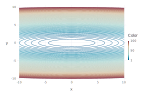

In [4]:
plot(z=f, x=linspace(-10, 10, 100), y=linspace(-10, 10, 100), Geom.contour(levels=0:100))

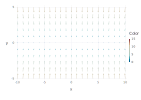

In [5]:
a0 = [-2.0:0.25:2.0;]
x = repmat(-10.0:10.0,11)
y = vec(repmat((-5.0:5.0)',21))
f2(x::Vector) = f(x...)
gxy = mapslices(v->numerical_gradient(f2, v), [x y;], 2)
exy = [x y;] - 2gxy ./ 3maximum(gxy)
c = mapslices(norm, gxy, 2)
plot(
x=x, y=y, xend=exy[:,1], yend=exy[:,2], color=c, Geom.vector, 
# Guide.xlabel("x1"), Guide.ylabel("x2"), 
Scale.x_continuous(minvalue=-10.0, maxvalue=10.0),
Scale.y_continuous(minvalue=-5.0, maxvalue=5.0),
Coord.cartesian(xmin=-10.0, xmax=10.0, ymin=-5.0, ymax=5.0))

In [6]:
numerical_gradient(f2, Float32[-7.0, 2.0])

2-element Array{Float32,1}:
 -0.698566
  4.00066 

## 6.1 パラメータの更新

In [7]:
abstract AbstractOptimizer{T<:AbstractFloat}

### 6.1.2 SGD

In [8]:
immutable SGD{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
end

In [9]:
function update{T,N}(optimizer::SGD{T}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(param) == size(grad)
    param - optimizer.lr .* grad
end

update (generic function with 1 method)

In [10]:
xs = Float32[]
ys = Float32[]
optimizer = SGD(Float32(0.95))

SGD{Float32}(0.95f0)

In [11]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
for _=1:30
    grad = numerical_gradient(f2, param)
    param = update(optimizer, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

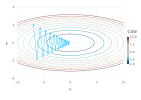

In [12]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.4 Momentum

In [13]:
immutable Momentum{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
    momentum::T
end

(::Type{Momentum{T}}){T}(lr::T=0.01, momentum::T=0.9) = Momentum(lr, momentum)
(::Type{Momentum}){T}(lr::T) = Momentum(lr, T(0.9))

In [14]:
function update{T,N}(optimizer::Momentum{T}, v::AbstractArray{T,N}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(v) == size(param) == size(grad)
    new_v = optimizer.momentum .* v .- optimizer.lr .* grad
    (new_v, param .+ new_v)
end

update (generic function with 2 methods)

In [15]:
xs = Float32[]
ys = Float32[]
optimizer = Momentum(Float32(0.1), Float32(0.9))

Momentum{Float32}(0.1f0,0.9f0)

In [16]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
v = zeros(param)
for _=1:30
    grad = numerical_gradient(f2, param)
    (v, param) = update(optimizer, v, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

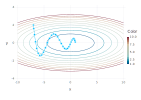

In [17]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.5 AdaGrad

In [18]:
immutable AdaGrad{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
end

(::Type{AdaGrad{T}}){T}(lr::T=0.01) = AdaGrad(lr)

In [19]:
function update{T,N}(optimizer::AdaGrad{T}, h::AbstractArray{T,N}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(h) == size(param) == size(grad)
    δ = T(1e-7)
    new_h = h .+ grad .* grad
    (new_h, param .- optimizer.lr .* grad ./ (sqrt.(new_h) + δ))
end

update (generic function with 3 methods)

In [20]:
xs = Float32[]
ys = Float32[]
optimizer = AdaGrad(Float32(1.5))

AdaGrad{Float32}(1.5f0)

In [21]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
h = zeros(param)
for _=1:30
    grad = numerical_gradient(f2, param)
    (h, param) = update(optimizer, h, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

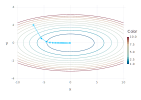

In [22]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.6 Adam

In [23]:
immutable Adam{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
    β1::T
    β2::T
end

(::Type{Adam{T}}){T}(lr::T=0.001) = Adam(lr,T(0.9),T(0.999))
(::Type{Adam}){T}(lr::T,β1::T=T(0.9),β2::T=T(0.999)) = Adam(lr,β1,β2)

In [24]:
Adam(Float32(0.001))

Adam{Float32}(0.001f0,0.9f0,0.999f0)

In [25]:
type AdamParams{T}
    iter::Int
    m::AbstractArray{T}
    v::AbstractArray{T}
end

In [26]:
function update{T,N}(optimizer::Adam{T}, ap::AdamParams{T}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(h) == size(param) == size(grad)
    δ = T(1e-7)
    new_iter = ap.iter + 1
    lr_t = optimizer.lr * sqrt(one(T) - optimizer.β2^new_iter) / (1.0 - optimizer.β1^new_iter)
    new_m = ap.m .+ (1 - optimizer.β1) .* (grad .- ap.m)
    new_v = ap.v .+ (1 - optimizer.β2) .* (grad.^2 .- ap.v)
    new_ap = AdamParams(new_iter, new_m, new_v)
    (new_ap, param .- lr_t .* new_m ./ (sqrt.(new_v) + δ))
end

update (generic function with 4 methods)

In [27]:
xs = Float32[]
ys = Float32[]
optimizer = Adam(Float32(0.3))

Adam{Float32}(0.3f0,0.9f0,0.999f0)

In [28]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
ap = AdamParams(0, zeros(param), zeros(param))
for _=1:30
    grad = numerical_gradient(f2, param)
    (ap, param) = update(optimizer, ap, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

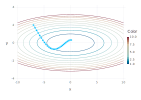

In [29]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)